### Часть 1

In [ ]:
!pip install kaggle
!pip install findspark
!sudo apt install unzip
!sudo apt-get install p7zip-full

!export KAGGLE_USERNAME='borispanfilov'
!export KAGGLE_KEY='23e1a26705b833184e1835da72c45fe3'

!kaggle competitions download -c avito-context-ad-clicks -f trainSearchStream.tsv.7z
!kaggle competitions download -c avito-context-ad-clicks -f testSearchStream.tsv.7z
!kaggle competitions download -c avito-context-ad-clicks -f SearchInfo.tsv.7z
!kaggle competitions download -c avito-context-ad-clicks -f AdsInfo.tsv.7z
!kaggle competitions download -c avito-context-ad-clicks -f UserInfo.tsv.7z
!kaggle competitions download -c avito-context-ad-clicks -f Location.tsv.7z

In [237]:
!7z x trainSearchStream.tsv.7z
!7z x testSearchStream.tsv.7z
!7z x SearchInfo.tsv.7z
!7z x AdsInfo.tsv.7z
!7z x UserInfo.tsv.7z
!7z x Location.tsv.7z

In [13]:
! head -n 5 trainSearchStream.tsv

SearchID	AdID	Position	ObjectType	HistCTR	IsClick
2	11441863	1	3	0.001804	0
2	22968355	7	3	0.004723	0
3	212187	7	3	0.029701	0
3	34084553	1	3	0.004300	0


In [11]:
! head -n 10 testSearchStream.tsv

ID	SearchID	AdID	Position	ObjectType	HistCTR
1	1	10915336	1	3	0.004999
2	1	12258424	6	1	
3	1	15952399	2	1	
4	1	17092357	8	1	
5	1	31173651	7	3	0.045094
6	7	9041972	1	3	0.007032
7	28	14309446	7	3	0.016943
8	28	15753167	1	3	0.054339
9	28	20744962	2	2	


In [7]:
! head -n 5 SearchInfo.tsv

SearchID	SearchDate	IPID	UserID	IsUserLoggedOn	SearchQuery	LocationID	CategoryID	SearchParams
1	2015-05-18 19:54:32.0	1717090	3640266	0		1729	5	
2	2015-05-12 14:21:28.0	1731568	769304	0		697	50	
3	2015-05-12 07:09:42.0	793143	640089	0		1261	12	
4	2015-05-10 18:11:01.0	898705	3573776	0		3960	22	{83:'Обувь', 175:'Женская одежда', 88:'38'}


In [8]:
! head -n 5 AdsInfo.tsv

AdID	LocationID	CategoryID	Params	Price	Title	IsContext
1	343	43	{1283:'С пробегом', 633:'Синий', 1159:0, 210:'Toyota', 184:'0 - 4 999', 1162:0, 1165:0, 1135:0, 1329:'2.0', 1138:0, 277:'Estima', 695:'Полный', 696:'правый', 697:'Не битый', 186:'Дизель', 187:'Микроавтобус', 188:'1993', 185:'Механика'}	160000	Toyota Estima, 1993	0
2	992	34	{817:'Кузов', 5:'Запчасти', 598:'Для автомобилей'}	750	Передние брызговики Форд Фокус 2 родные	0
3	3771	53	{181:'Промышленное'}	18000	Дровокол	0
4	4294	57	{130:'Приборы и аксессуары'}	1500	Продам ходули складные	0


In [9]:
! head -n 5 UserInfo.tsv

UserID	UserAgentID	UserAgentOSID	UserDeviceID	UserAgentFamilyID
1	44073	30	2019	9
2	12505	20	2014	85
3	24256	20	2014	64
4	57133	20	2014	25


In [14]:
! head -n 5 Location.tsv

LocationID	Level	RegionID	CityID
7	3	83	2386
23	3	28	3224
26	3	41	1316
30	3	63	2565


In [25]:
!hdfs dfs -mkdir /user/input

!hdfs dfs -put trainSearchStream.tsv /user/input/trainSearchStream.tsv
!hdfs dfs -put testSearchStream.tsv /user/input/testSearchStream.tsv
!hdfs dfs -put SearchInfo.tsv /user/input/SearchInfo.tsv
!hdfs dfs -put AdsInfo.tsv /user/input/AdsInfo.tsv
!hdfs dfs -put UserInfo.tsv /user/input/UserInfo.tsv
!hdfs dfs -put Location.tsv /user/input/Location.tsv

Запустим spark

In [68]:
spark.stop()

In [69]:
import findspark
findspark.init()

In [70]:
from pyspark.sql import SparkSession
import pyspark

sc = pyspark.SparkContext(appName="ContextualAdsFeatureEngineering")
spark = SparkSession(sc)

Подгружаем данные и джойним таблицы

In [71]:
from pyspark.sql.functions import col, when, length

train = spark.read.csv("/user/input/trainSearchStream.tsv", sep="\t", header=True)
test = spark.read.csv("/user/input/testSearchStream.tsv", sep="\t", header=True)
search_info = spark.read.csv("/user/input/SearchInfo.tsv", sep="\t", header=True)
ads_info = spark.read.csv("/user/input/AdsInfo.tsv", sep="\t", header=True)
user_info = spark.read.csv("/user/input/UserInfo.tsv", sep="\t", header=True)

search_info = search_info.withColumnRenamed("CategoryID", "SearchCategoryID")
search_info = search_info.withColumnRenamed("LocationID", "SearchLocationID")

train_context = train.filter(col("ObjectType") == 3)
test_context = test.filter(col("ObjectType") == 3)

In [27]:
print('train length:', train.count())
print('filtered train length:', train_context.count())
print('test length:', test.count())
print('filtered test length:', test_context.count())

train length: 392356948
filtered train length: 190157735
test length: 15961515
filtered test length: 7816361


In [72]:
from pyspark import StorageLevel

fraction = 40000000 / 190157735
train_context = train_context.sample(withReplacement=False, fraction=fraction)

train_context.persist(StorageLevel.MEMORY_AND_DISK)
train_context.count()

39996293

In [73]:
from pyspark.ml.feature import OneHotEncoder
from pyspark.sql.functions import udf, col, when, length, lit
from pyspark.sql.types import IntegerType, DoubleType

features = ["UserID", "IsUserLoggedOn", "SearchQuery", "Position", "HistCTR", "Price", "CategoryID", \
                  "UserAgentFamilyID", "UserDeviceID", "Params"]
test_features = features + ["ID"]
train_features = features + ["IsClick"]


train_context = train_context.join(search_info, on="SearchID", how="left") \
                             .join(ads_info, on="AdID", how="left") \
                             .join(user_info, on="UserID", how="left") \
                             .select(train_features)

test_context = test_context.join(search_info, on="SearchID", how="left") \
                           .join(ads_info, on="AdID", how="left") \
                           .join(user_info, on="UserID", how="left") \
                           .select(test_features) \
                           .withColumn("IsClick", col("ID").cast("int"))

train_context.persist(StorageLevel.MEMORY_AND_DISK)
print(train_context.count())

test_context.persist(StorageLevel.MEMORY_AND_DISK)
print(test_context.count())

39996293
7816361


### Сначала я думал последовательно добавлять каждый признак, но потом понял, что их добавиление весьма однообразно, поэтому сначала опишу каждый из признаков, который я буду добавлять, а затем приведу код, добавляющий их.

Описание будующих признаков:

1. IsUserLoggedOn

Обоснование:
Этот бинарный признак отражает, вошёл ли пользователь в систему. Зарегистрированные пользователи часто проявляют более целенаправленное поведение, что может сказываться на вероятности клика. Анализируя разницу между авторизованными и неавторизованными пользователями, можно выявить важные паттерны вовлечённости и доверия к сервису.

Для этого признака сделаем OHE, так как 0 и 1 особого смысла не несут. Это просто 2 разные категории пользователей.

2. QueryLength

Обоснование:
Длина поискового запроса (в символах или словах) позволяет оценить, насколько конкретен или общий запрос пользователя. Более длинные запросы, как правило, свидетельствуют о более детальном намерении, что может указывать на высокий интерес к определённой категории товаров или услуг. Этот признак помогает понять степень намеренности пользователя.


3. Position

Обоснование:
Позиция объявления на странице результатов играет важную роль: объявления, расположенные ближе к началу, обычно привлекают больше внимания и, соответственно, имеют более высокую вероятность клика. Этот признак напрямую отражает видимость объявления для пользователя и помогает корректировать эффект «первой позиции».

4. HistCTR

Обоснование:
Исторический CTR (Click-Through Rate) для контекстной рекламы является наглядным индикатором привлекательности объявления. Если ранее по похожим объявлениям наблюдалась высокая кликабельность, это может свидетельствовать о высоком качестве или релевантности конкретного объявления. Несмотря на то, что для не-контекстных объявлений значение отсутствует, для целевого сегмента это — важный сигнал.


5. Price

Обоснование:
Цена объявления может оказывать существенное влияние на поведение пользователей. Определённые ценовые диапазоны могут быть более привлекательными для аудитории, тогда как слишком высокая или слишком низкая цена может снижать вероятность клика. Анализируя ценовой диапазон, можно оценить, насколько цена коррелирует с намерением совершения перехода.

6. CategoryID

Обоснование:
Категория объявления отражает тип товара или услуги и позволяет разделить объявления на логические группы. Различные категории часто имеют различные кликабельные паттерны, поэтому включение этого признака помогает модели учитывать особенности спроса и поведения в каждой конкретной категории.

Для этого признака тоже сделаем OHE.

7. Params_Count

Обоснование:
Количество параметров в поле Params является индикатором детализированности и полноты описания объявления. Объявления с большим числом параметров могут восприниматься как более информативные, что может положительно сказываться на доверии пользователей и, соответственно, на вероятности клика.

8. UserAgentFamilyID

Обоснование:
Признак, характеризующий семейство браузера, позволяет разделить пользователей по типу используемого программного обеспечения. Различия в поведении пользователей, использующих, например, Chrome или Safari, могут быть связаны с различиями в устройстве, привычках или даже географическим распределением. Это помогает выявить скрытые паттерны в пользовательском поведении.

Для этого признака тоже сделаем OHE.

9. UserDeviceID

Обоснование:
Модель телефона многое говорит о человеке и его состоянии в наше время. А значит такие данные могут помочь в прогнозировании потенциальной возможности человека купить тот или иной товар. То есть это может сильно влиять и на вероятность клика.

Для этого признака тоже сделаем OHE.

10. HistoricalUserActivity

Обоснование:
Этот агрегированный признак отражает общую активность пользователя за определённый период (например, количество поисковых событий, просмотров или телефонных запросов). Высокая активность может указывать на вовлечённость и заинтересованность, тогда как низкая активность может свидетельствовать о нерегулярном использовании сервиса. Такой признак помогает дифференцировать пользователей по уровню их взаимодействия с платформой.

Варим признаки и готовимся к обучению:

In [74]:
from pyspark.ml.feature import OneHotEncoder, VectorAssembler
from pyspark.sql.functions import udf, col, when, length, lit
from pyspark.sql.types import IntegerType, DoubleType, StringType


def count_params(params):
    if params is None or params.strip() == "":
        return 0
    params = params.strip("{}")
    if params == "":
        return 0
    return len(params.split(','))

count_params_udf = udf(count_params, IntegerType())

def ensure_column(df, col_name, dtype, default_value):
    return df.withColumn(col_name, when(col(col_name).isNotNull(), col(col_name)).otherwise(lit(default_value).cast(dtype)))

def get_features_from_data(data):
    data = ensure_column(data, "UserID", IntegerType(), -1)
    data = ensure_column(data, "IsUserLoggedOn", IntegerType(), 0)
    data = ensure_column(data, "SearchQuery", StringType(), "")
    data = ensure_column(data, "Position", IntegerType(), -1)
    data = ensure_column(data, "HistCTR", DoubleType(), 0.0)
    data = ensure_column(data, "Price", DoubleType(), 0.0)
    data = ensure_column(data, "CategoryID", IntegerType(), 0)
    data = ensure_column(data, "UserAgentFamilyID", IntegerType(), 0)
    data = ensure_column(data, "UserDeviceID", IntegerType(), 0)
    data = ensure_column(data, "Params", StringType(), "")
    data = ensure_column(data, "IsClick", IntegerType(), 0)
    
    user_activity = data.groupBy("UserID").count().withColumnRenamed("count", "HistoricalUserActivity")

    data = data.withColumn("IsUserLoggedOn", col("IsUserLoggedOn").cast("int")) \
               .withColumn("QueryLength", length(col("SearchQuery")).cast("int")) \
               .withColumn("Position", col("Position").cast("int")) \
               .withColumn("HistCTR", col("HistCTR").cast("double")) \
               .withColumn("Price", col("Price").cast("double")) \
               .withColumn("CategoryID", col("CategoryID").cast("int")) \
               .withColumn("UserAgentFamilyID", col("UserAgentFamilyID").cast("int")) \
               .withColumn("UserDeviceID", col("UserDeviceID").cast("int")) \
               .withColumn("Params_Count", count_params_udf(col("Params"))) \
               .join(user_activity, on="UserID", how="left")


    single_col_ohe = OneHotEncoder(inputCol="IsUserLoggedOn", outputCol="IsUserLoggedOnOHE")
    single_col_model = single_col_ohe.fit(data)
    data = single_col_model.transform(data)

    single_col_ohe = OneHotEncoder(inputCol="CategoryID", outputCol="CategoryID_OHE")
    single_col_model = single_col_ohe.fit(data)
    data = single_col_model.transform(data)

    single_col_ohe = OneHotEncoder(inputCol="UserAgentFamilyID", outputCol="UserAgentFamilyID_OHE")
    single_col_model = single_col_ohe.fit(data)
    data = single_col_model.transform(data)

    single_col_ohe = OneHotEncoder(inputCol="UserDeviceID", outputCol="UserDeviceID_OHE")
    single_col_model = single_col_ohe.fit(data)
    data = single_col_model.transform(data)
    
    assembler = VectorAssembler(
        inputCols=["IsUserLoggedOnOHE", "QueryLength", "Position", "HistCTR", "Price", "CategoryID_OHE", "UserAgentFamilyID_OHE", "UserDeviceID_OHE", "Params_Count", "HistoricalUserActivity"],
        outputCol="features"
    )
    return assembler.transform(data)

In [75]:
train_df = get_features_from_data(train_context)
test_df = get_features_from_data(test_context)

train_df.persist(StorageLevel.MEMORY_AND_DISK)
print(train_df.count())

test_df.persist(StorageLevel.MEMORY_AND_DISK)
print(test_df.count())

39996293
7816361


Переводим в vw формат

In [76]:
def train_to_vw(is_click, features):
    label = "1" if int(is_click) == 1 else "-1"
    if features is None:
        features_str = ""
    else:
        features_str = " ".join(f"{i}:{v}" for i, v in zip(features.indices, features.values))
    return f"{label} |f {features_str}"

def test_to_vw(is_click, features):
    label = int(is_click)
    if features is None:
        features_str = ""
    else:
        features_str = " ".join(f"{i}:{v}" for i, v in zip(features.indices, features.values))
    return f"{label} |f {features_str}"

train_to_vw_udf = udf(train_to_vw, StringType())
test_to_vw_udf = udf(test_to_vw, StringType())

train_df, val_df = train_df.randomSplit([0.8, 0.2], seed=42)

train_df_vw = train_df.withColumn("vw_line", train_to_vw_udf("IsClick", "features"))
val_df_vw = val_df.withColumn("vw_line", train_to_vw_udf("IsClick", "features"))
test_df_vw = test_df.withColumn("vw_line", test_to_vw_udf("IsClick", "features"))

train_df_vw.select("vw_line").write.text("/user/ubuntu/train_df.vw")
val_df_vw.select("vw_line").write.text("/user/ubuntu/val_df.vw")
test_df_vw.select("vw_line").write.text("/user/ubuntu/test_df.vw")

In [77]:
# ! hdfs dfs -rm -r /user/ubuntu/train_df.vw
# ! hdfs dfs -rm -r /user/ubuntu/test_df.vw
# ! hdfs dfs -rm -r /user/ubuntu/val_df.vw

# ! hdfs dfs -ls /user/ubuntu/

In [78]:
! hdfs dfs -cat /user/ubuntu/train_df.vw/* > train.vw
! hdfs dfs -cat /user/ubuntu/val_df.vw/* > val.vw
! hdfs dfs -cat /user/ubuntu/test_df.vw/* > test.vw

Обучаем

In [79]:
! vw \
    --final_regressor model.bin \
    --loss_function logistic \
    --learning_rate 20.0 \
    --bit_precision=22 \
    --passes=10 \
    --cache -k \
    train.vw

final_regressor = model.bin
Num weight bits = 22
learning rate = 20
initial_t = 0
power_t = 0.5
decay_learning_rate = 1
creating cache_file = train.vw.cache
Reading datafile = train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
0.693147 0.693147            1            1.0  -1.0000   0.0000       10
0.351467 0.009787            2            2.0  -1.0000  -4.6218       10
0.177310 0.003153            4            4.0  -1.0000  -5.8995       10
0.089831 0.002352            8            8.0  -1.0000  -6.6459       10
0.045562 0.001293           16           16.0  -1.0000  -7.7473       10
0.022968 0.000374           32           32.0  -1.0000  -6.8093       10
0.011818 0.000669           64           64.0  -1.0000  -7.2493       10
0.006598 0.001378          128          128.0  -1.0000 -12.4866       10
0.066019 0.125439          256          256.0  -1.0000  -7.4868      

In [80]:
! vw \
    --link=logistic \
    --testonly \
    --initial_regressor model.bin \
    --predictions val_predictions.txt \
    val.vw

only testing
predictions = val_predictions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = val.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
15.964691 15.964691            1            1.0  -1.0000   0.0067       10
17.728201 19.491711            2            2.0  -1.0000   0.0044       10
18.598929 19.469658            4            4.0  -1.0000   0.0045       10
18.120518 17.642106            8            8.0  -1.0000   0.0047       10
19.816864 21.513211           16           16.0  -1.0000   0.0064       10
19.782540 19.748216           32           32.0  -1.0000   0.0025       10
20.767967 21.753395           64           64.0  -1.0000   0.0031       10
19.640731 18.513495          128          128.0  -1.0000   0.0028       10
20.097295 20.553859          256          256.0  -1.0000   0.0063       10
20.964

In [81]:
! vw \
    --link=logistic \
    --testonly \
    --initial_regressor model.bin \
    --predictions test_predictions.txt \
    test.vw

only testing
predictions = test_predictions.txt
Num weight bits = 22
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1192769280.000000 1192769280.000000            1            1.0 34532.0000   0.0111       11
77856668130176.000000 155712143491072.000000            2            2.0 12478462.0000   0.0045       10
80419667185088.000000 82982666240000.000000            4            4.0 3202068.0000   0.0056       10
89809995368160.000000 99200323551232.000000            8            8.0 7631643.0000   0.0220       11
63685161108336.000000 37560326848512.000000           16           16.0 6238464.0000   0.0055       10
89070689829304.000000 114456218550272.000000           32           32.0 6306383.0000   0.0024       10
70801231296732.000000 52531772764160.000000           64           6

Замеряем метрики и экспортируем результаты теста

In [82]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
import pandas as pd

In [83]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, log_loss

def get_prediction_metrics(preds_file, gt_file, threshold=0.005):
    # Читаем файл предиктов
    with open(preds_file, 'r') as file:
        raw_preds = []
        y_pred = []
        for line in file.readlines():
            prob = float(line.strip())
            raw_preds.append(prob)
            predict = int(prob > threshold) * 2 - 1
            y_pred.append(predict)

    with open(gt_file, 'r') as file:
        y_true = []
        for line in file.readlines():
            gt = int(float(line.split(' ')[0]))
            y_true.append(gt)
    
    y_true_bin = [1 if label == 1 else 0 for label in y_true]
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    logloss = log_loss(y_true_bin, raw_preds)
    
    return accuracy, precision, recall, logloss


In [84]:
get_prediction_metrics("val_predictions.txt", "val.vw")

(0.607748625823937,
 0.009967872069249945,
 0.6529153943623938,
 0.03564372182969553)

In [85]:
def create_submit(preds_file, gt_file):
    with open(preds_file, 'r') as file:
        y_pred = []
        for line in file.readlines():
            predict = float(line)
            y_pred.append(predict)

    with open(gt_file, 'r') as file:
        ids = []
        for line in file.readlines():
            id_ = int(line.split(' ')[0])
            ids.append(id_)

    return pd.DataFrame({
        "ID": np.array(ids),
        "IsClick": np.array(y_pred)
    })

In [86]:
ans = create_submit("test_predictions.txt", "test.vw")
ans.to_csv("submit.csv", index=False)

In [90]:
!head -n 10 submit.csv

ID,IsClick
34532,0.011055
12478462,0.004544
12478458,0.002903
3202068,0.005583
3202067,0.003661
12812214,0.003209
12812216,0.00546
7631643,0.022004
7631642,0.013352


In [87]:
!wc -l submit.csv

7816362 submit.csv


In [88]:
!hdfs dfs -put -f submit.csv s3a://bspanfilov-lsml/hw3_submit2.csv

2025-03-11 10:51:59,416 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2025-03-11 10:51:59,482 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2025-03-11 10:51:59,482 INFO impl.MetricsSystemImpl: s3a-file-system metrics system started
2025-03-11 10:52:06,754 INFO impl.MetricsSystemImpl: Stopping s3a-file-system metrics system...
2025-03-11 10:52:06,754 INFO impl.MetricsSystemImpl: s3a-file-system metrics system stopped.
2025-03-11 10:52:06,755 INFO impl.MetricsSystemImpl: s3a-file-system metrics system shutdown complete.


In [89]:
!hdfs dfs -ls s3a://bspanfilov-lsml/

2025-03-11 10:52:07,806 INFO impl.MetricsConfig: Loaded properties from hadoop-metrics2.properties
2025-03-11 10:52:07,873 INFO impl.MetricsSystemImpl: Scheduled Metric snapshot period at 10 second(s).
2025-03-11 10:52:07,873 INFO impl.MetricsSystemImpl: s3a-file-system metrics system started
Found 10 items
-rw-rw-rw-   1 ubuntu ubuntu        964 2025-02-10 06:56 s3a://bspanfilov-lsml/CategoryPriceCount.txt
-rw-rw-rw-   1 ubuntu ubuntu        142 2025-02-24 14:48 s3a://bspanfilov-lsml/hw2_part1_top10_users
-rw-rw-rw-   1 ubuntu ubuntu        171 2025-02-25 09:13 s3a://bspanfilov-lsml/hw2_part2_1_top10_words.csv
-rw-rw-rw-   1 ubuntu ubuntu         20 2025-02-24 18:59 s3a://bspanfilov-lsml/hw2_part2_2_daily_users.csv
-rw-rw-rw-   1 ubuntu ubuntu        546 2025-02-24 21:35 s3a://bspanfilov-lsml/hw2_part2_3_unique_users_per_day_excluding_daily.csv
-rw-rw-rw-   1 ubuntu ubuntu        299 2025-02-25 09:04 s3a://bspanfilov-lsml/hw2_part2_4_top10_correlations.csv
-rw-rw-rw-   1 ubuntu ubuntu

Результаты сабмита

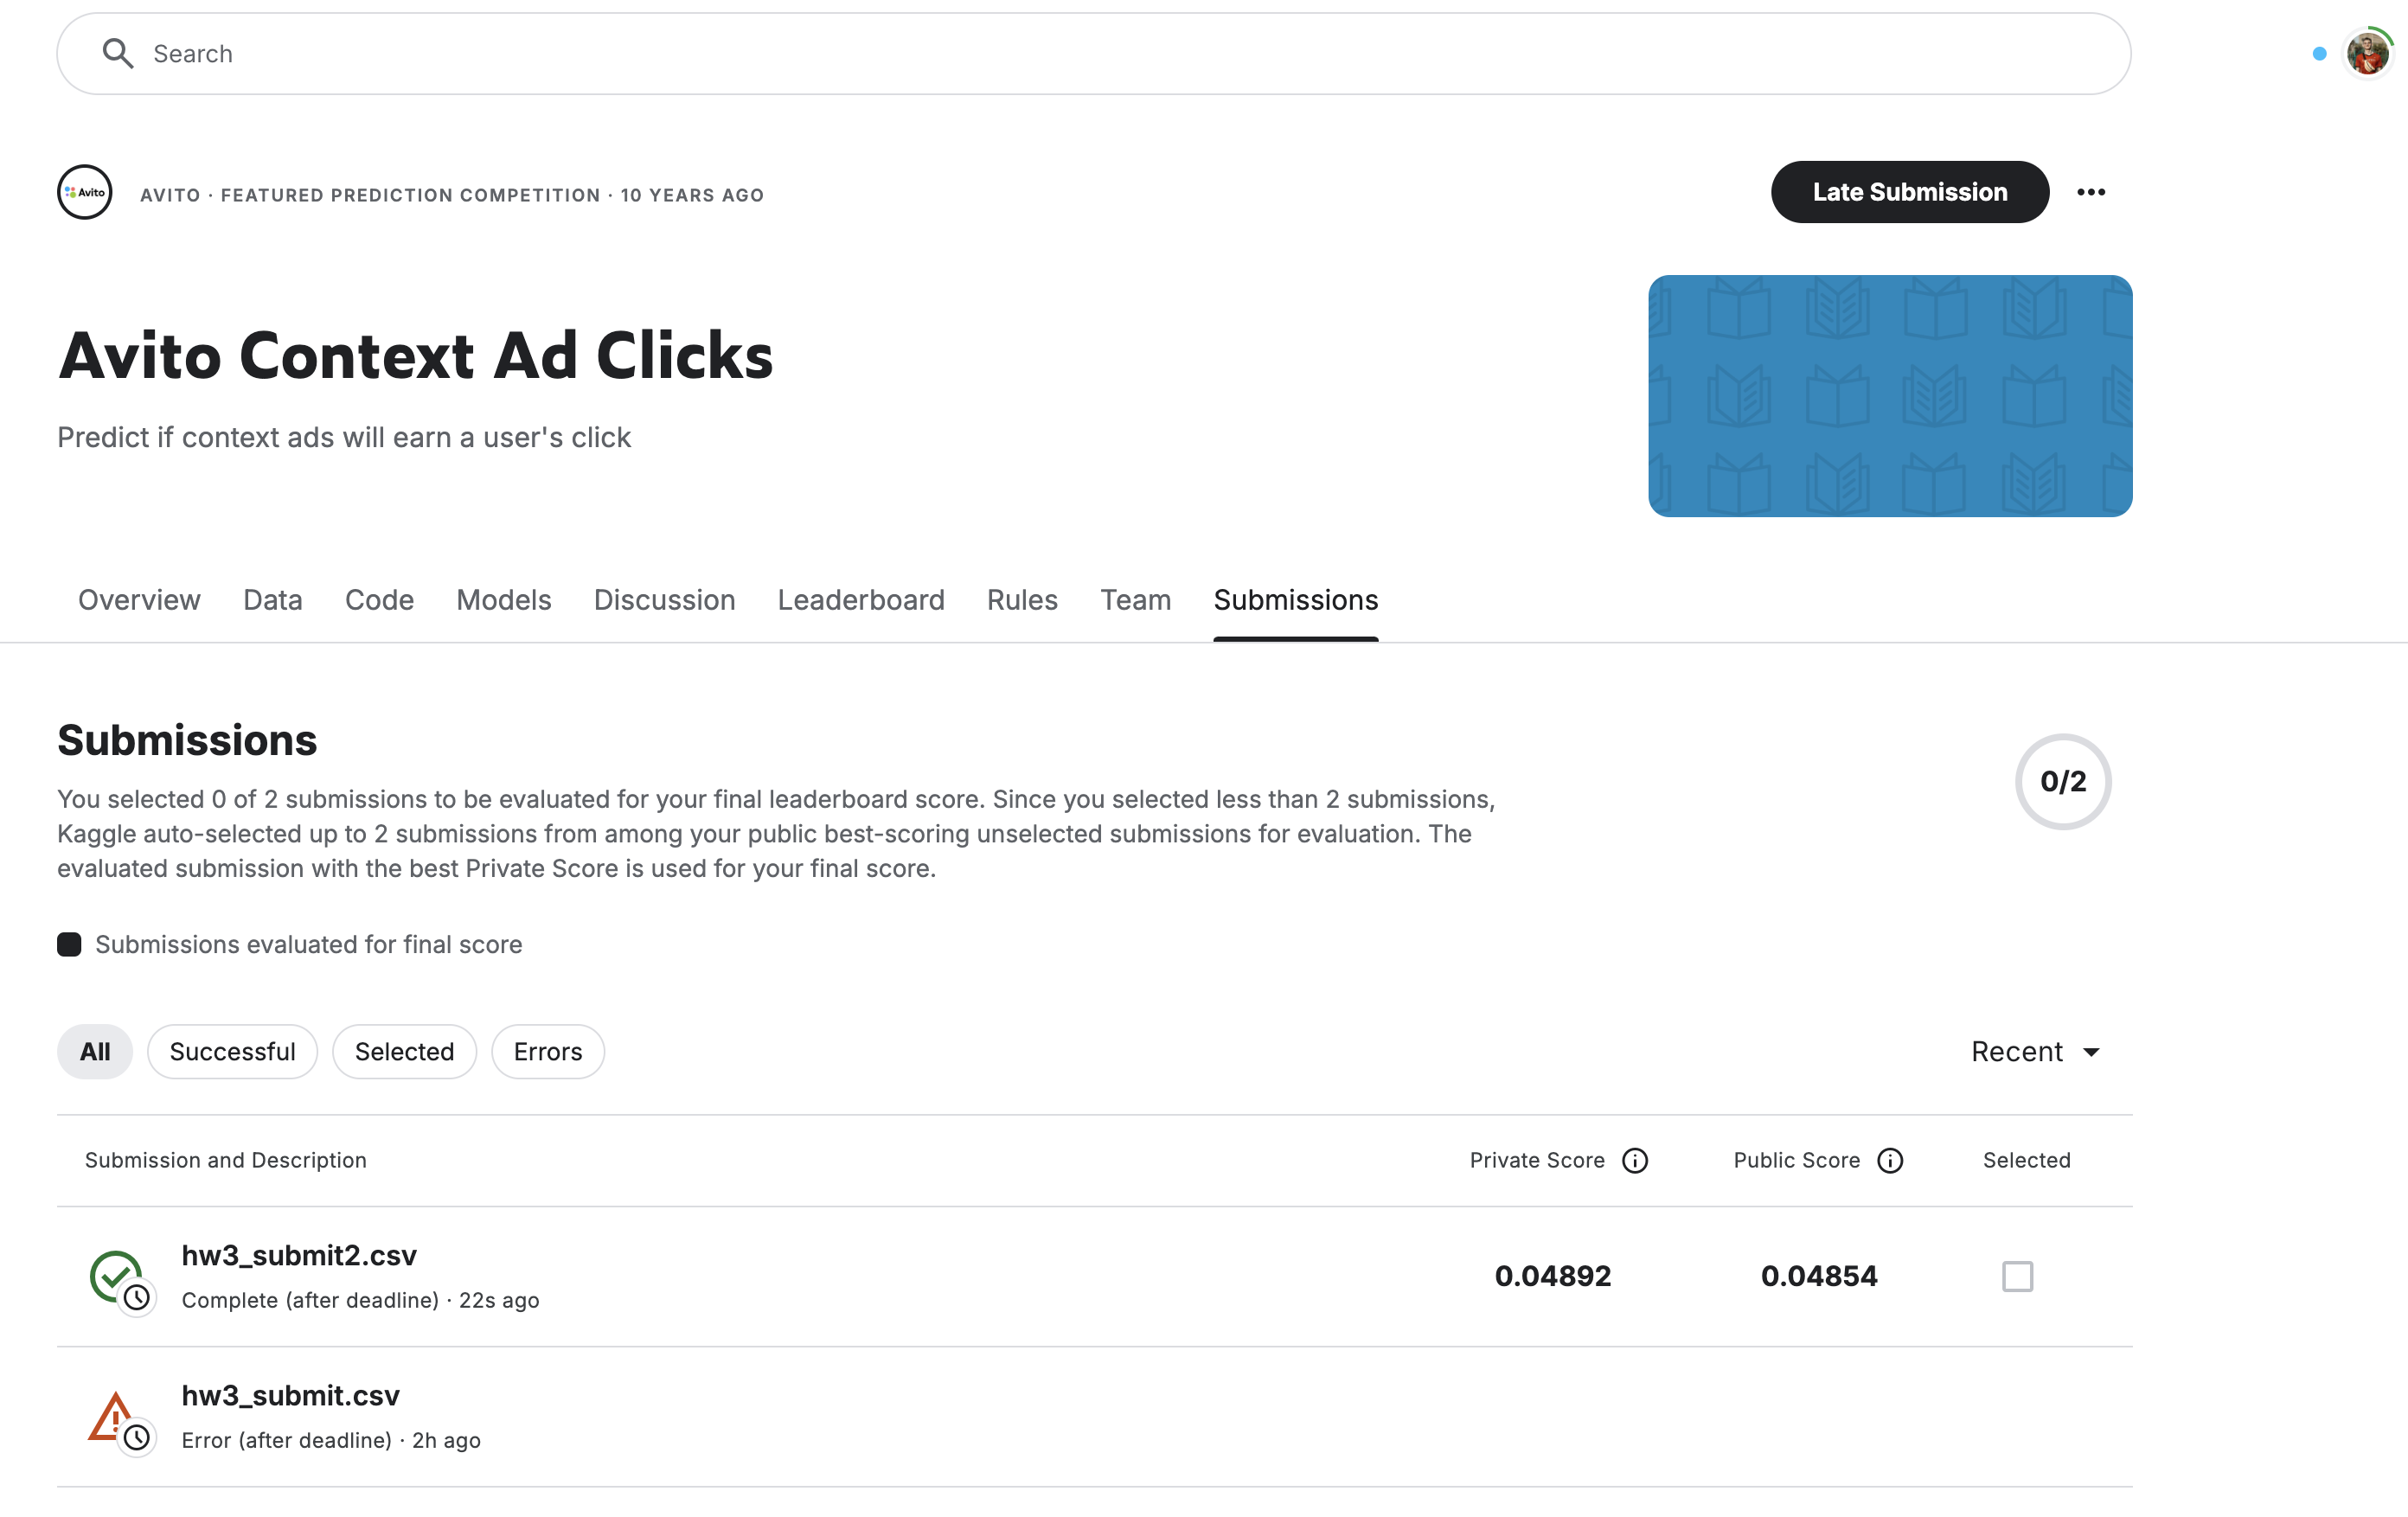

https://disk.yandex.ru/i/ctHRUYvaXVUwFA ссылка на скриншот на всякий

Конец)